In [198]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Data visualization

In [199]:
data = pd.read_csv('usdata.csv', header = None)

In [200]:
start_date = "30/09/1947"
end_date = "31/12/2004"
data.index = pd.date_range(start_date, end_date, freq='Q')
data.columns = ['dc', 'dinve', 'dy', 'labobs', 'pinfobs', 'dw', 'robs']

In [201]:
data

,dc,dinve,dy,labobs,pinfobs,dw,robs
1947-09-30,0.125190,3.745902,-0.346647,2.405991,1.733213,-0.390911,0.209167
1947-12-31,-0.311351,7.863267,1.151612,3.120085,2.482240,0.149491,0.251667
1948-03-31,0.429219,3.036307,1.160385,3.722781,0.760128,1.804115,0.272500
1948-06-30,1.102048,1.053555,1.533762,3.705329,0.883676,0.374202,0.275000
1948-09-30,-0.514536,-0.054367,0.247688,3.716847,1.840954,0.628307,0.287500
...,...,...,...,...,...,...,...
2003-12-31,0.477771,2.487176,0.681041,-2.091594,0.352658,0.637123,0.251667
2004-03-31,1.062724,0.843084,1.017161,-1.887397,0.676434,-0.152529,0.250833
2004-06-30,0.134491,3.271152,0.579111,-2.287390,0.786671,0.640072,0.252500
2004-09-30,0.890421,2.167986,0.664565,-1.879071,0.359229,0.983931,0.358333


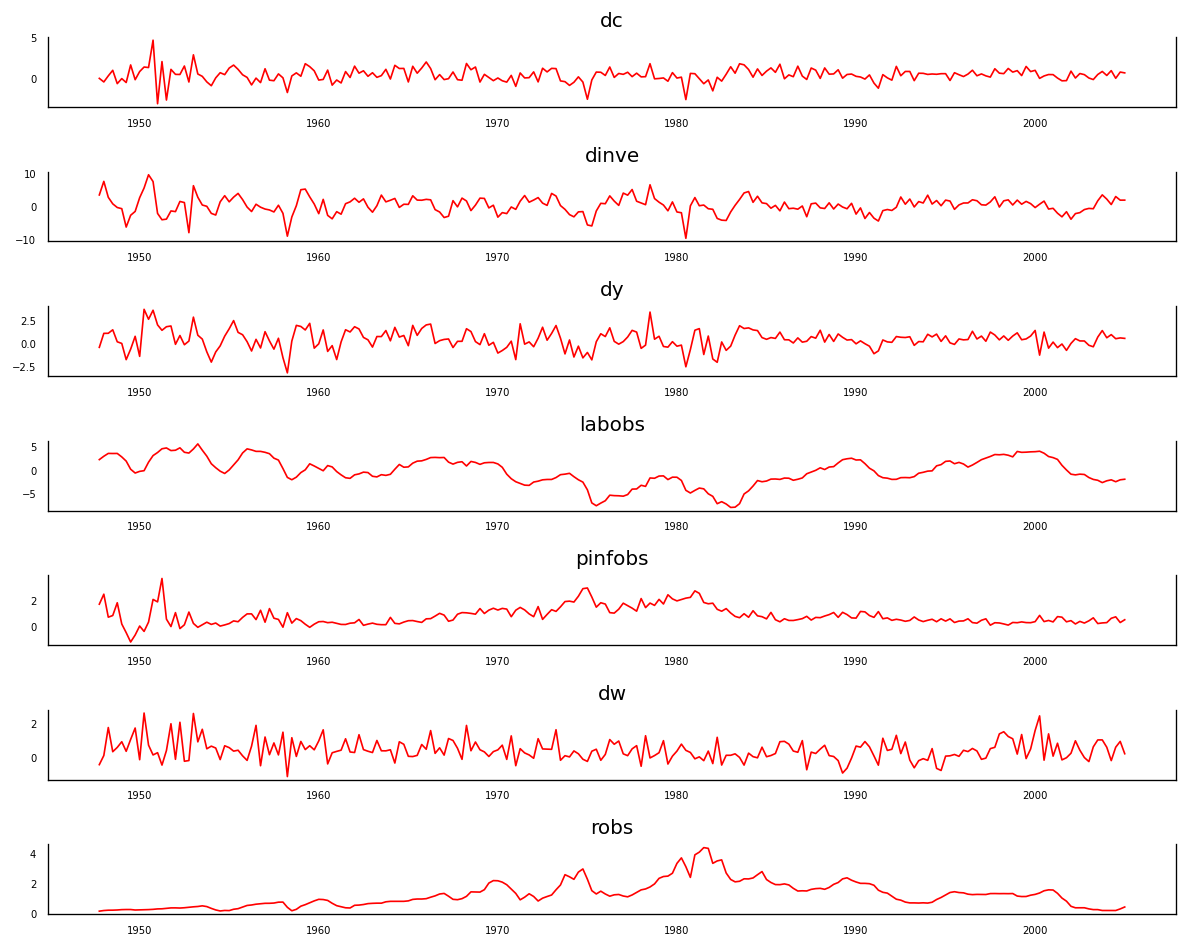

In [202]:
# Plot
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data_temp = data[data.columns[i]]
    ax.plot(data_temp, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Vector-autoregression model

## Train-test split

In [203]:
# train-test split without shuffling
nobs = 8
train, test = data[0:-nobs], data[-nobs:]
X_train, Y_train = train[0:-nobs], train[-nobs:]

## Stationarity check

In [204]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [205]:
print('Augmented Dickey-Fuller Test: Consumption Time Series')
augmented_dickey_fuller_statistics(X_train['dc'])
print('Augmented Dickey-Fuller Test: Investment Time Series')
augmented_dickey_fuller_statistics(X_train['dinve'])
print('Augmented Dickey-Fuller Test: Output Time Series')
augmented_dickey_fuller_statistics(X_train['dy'])
print('Augmented Dickey-Fuller Test: Labor Time Series')
augmented_dickey_fuller_statistics(X_train['labobs'])
print('Augmented Dickey-Fuller Test: Inflation Time Series')
augmented_dickey_fuller_statistics(X_train['pinfobs'])
print('Augmented Dickey-Fuller Test: Wage Time Series')
augmented_dickey_fuller_statistics(X_train['dw'])
print('Augmented Dickey-Fuller Test: Federal Funds Rate Time Series')
augmented_dickey_fuller_statistics(X_train['robs'])

Augmented Dickey-Fuller Test: Consumption Time Series
ADF Statistic: -7.959492
p-value: 0.000000
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Investment Time Series
ADF Statistic: -5.537069
p-value: 0.000002
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Output Time Series
ADF Statistic: -10.310731
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Labor Time Series
ADF Statistic: -3.024506
p-value: 0.032668
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Inflation Time Series
ADF Statistic: -3.149142
p-value: 0.023124
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Wage Time Series
ADF Statistic: -4.000188
p-value: 0.001410
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Federal Funds Rate Time Series
ADF Statistic: -2.130093
p-value: 0.232587
Critical V

## Order selection

In [206]:
model = VAR(X_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.564053753587929
BIC :  -6.680333747579818
FPE :  0.000518896408401419
HQIC:  -7.206913084889726 

Lag Order = 2
AIC :  -7.669763399630522
BIC :  -6.007303216420327
FPE :  0.0004675027082695002
HQIC:  -6.997835826719727 

Lag Order = 3
AIC :  -7.715446877857663
BIC :  -5.269067007927264
FPE :  0.0004482665843704257
HQIC:  -6.726571545605622 

Lag Order = 4
AIC :  -7.640882727145163
BIC :  -4.4053454474516105
FPE :  0.000486414014112377
HQIC:  -6.3328749124129295 

Lag Order = 5
AIC :  -7.528457884960886
BIC :  -3.498466346706663
FPE :  0.0005507801522184765
HQIC:  -5.8991086391165855 

Lag Order = 6
AIC :  -7.521880171227661
BIC :  -2.6920774693521965
FPE :  0.0005645064864440195
HQIC:  -5.568955956008732 

Lag Order = 7
AIC :  -7.449869570859264
BIC :  -1.8148377948067083
FPE :  0.0006225415865785282
HQIC:  -5.1711118874345745 

Lag Order = 8
AIC :  -7.342372450316382
BIC :  -0.8966317156219983
FPE :  0.0007182414425673967
HQIC:  -4.735497461399818 

Lag Order =

By AIC, we choose lag 3.

## Train the model

In [207]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 28, Aug, 2021
Time:                     20:54:13
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -5.26907
Nobs:                     211.000    HQIC:                  -6.72657
Log likelihood:          -1127.79    FPE:                0.000448267
AIC:                     -7.71545    Det(Omega_mle):     0.000223884
--------------------------------------------------------------------
Results for equation dc
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.037685         0.193330            5.367           0.000
L1.dc             -0.428698         0.094254           -4.548           0.000
L1.dinve           0.008954         0.032827            0.273           0.7

## Check for serial correlation of residuals

In [208]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

dc : 1.96
dinve : 1.97
dy : 1.98
labobs : 1.98
pinfobs : 1.96
dw : 1.97
robs : 1.94


## Forecast

In [209]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

3


array([[ 0.711647  , -1.61049329,  0.34085369, -0.68008592,  0.44463593,
         0.46350862,  0.4375    ],
       [ 0.57708493, -0.67542912,  0.33625692, -0.75188355,  0.31899486,
         0.02810719,  0.435     ],
       [ 0.16804908, -0.33038731, -0.12530637, -1.3975298 ,  0.48709396,
        -0.21027717,  0.36083333]])

In [210]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
data_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns)
data_forecast

,dc,dinve,dy,labobs,pinfobs,dw,robs
2003-03-31,0.702664,1.418921,1.005135,-1.210742,0.233141,0.552001,0.308415
2003-06-30,1.063478,2.959456,1.282328,-0.532957,0.154605,0.400671,0.350483
2003-09-30,1.158388,2.917860,1.354023,0.085287,0.242951,0.512469,0.416397
2003-12-31,0.964703,2.904340,1.294538,0.721526,0.307332,0.523093,0.461781
2004-03-31,0.990605,2.484532,1.184499,1.287397,0.378156,0.543664,0.523849
2004-06-30,0.852993,2.030081,1.091153,1.753563,0.425294,0.542265,0.593579
2004-09-30,0.776912,1.591791,0.931383,2.076919,0.468792,0.585165,0.650993
2004-12-31,0.686868,1.220091,0.807525,2.282976,0.491248,0.589051,0.699106


In [211]:
data_forecast.columns = [str(col) + '_forecast' for col in data_forecast.columns]

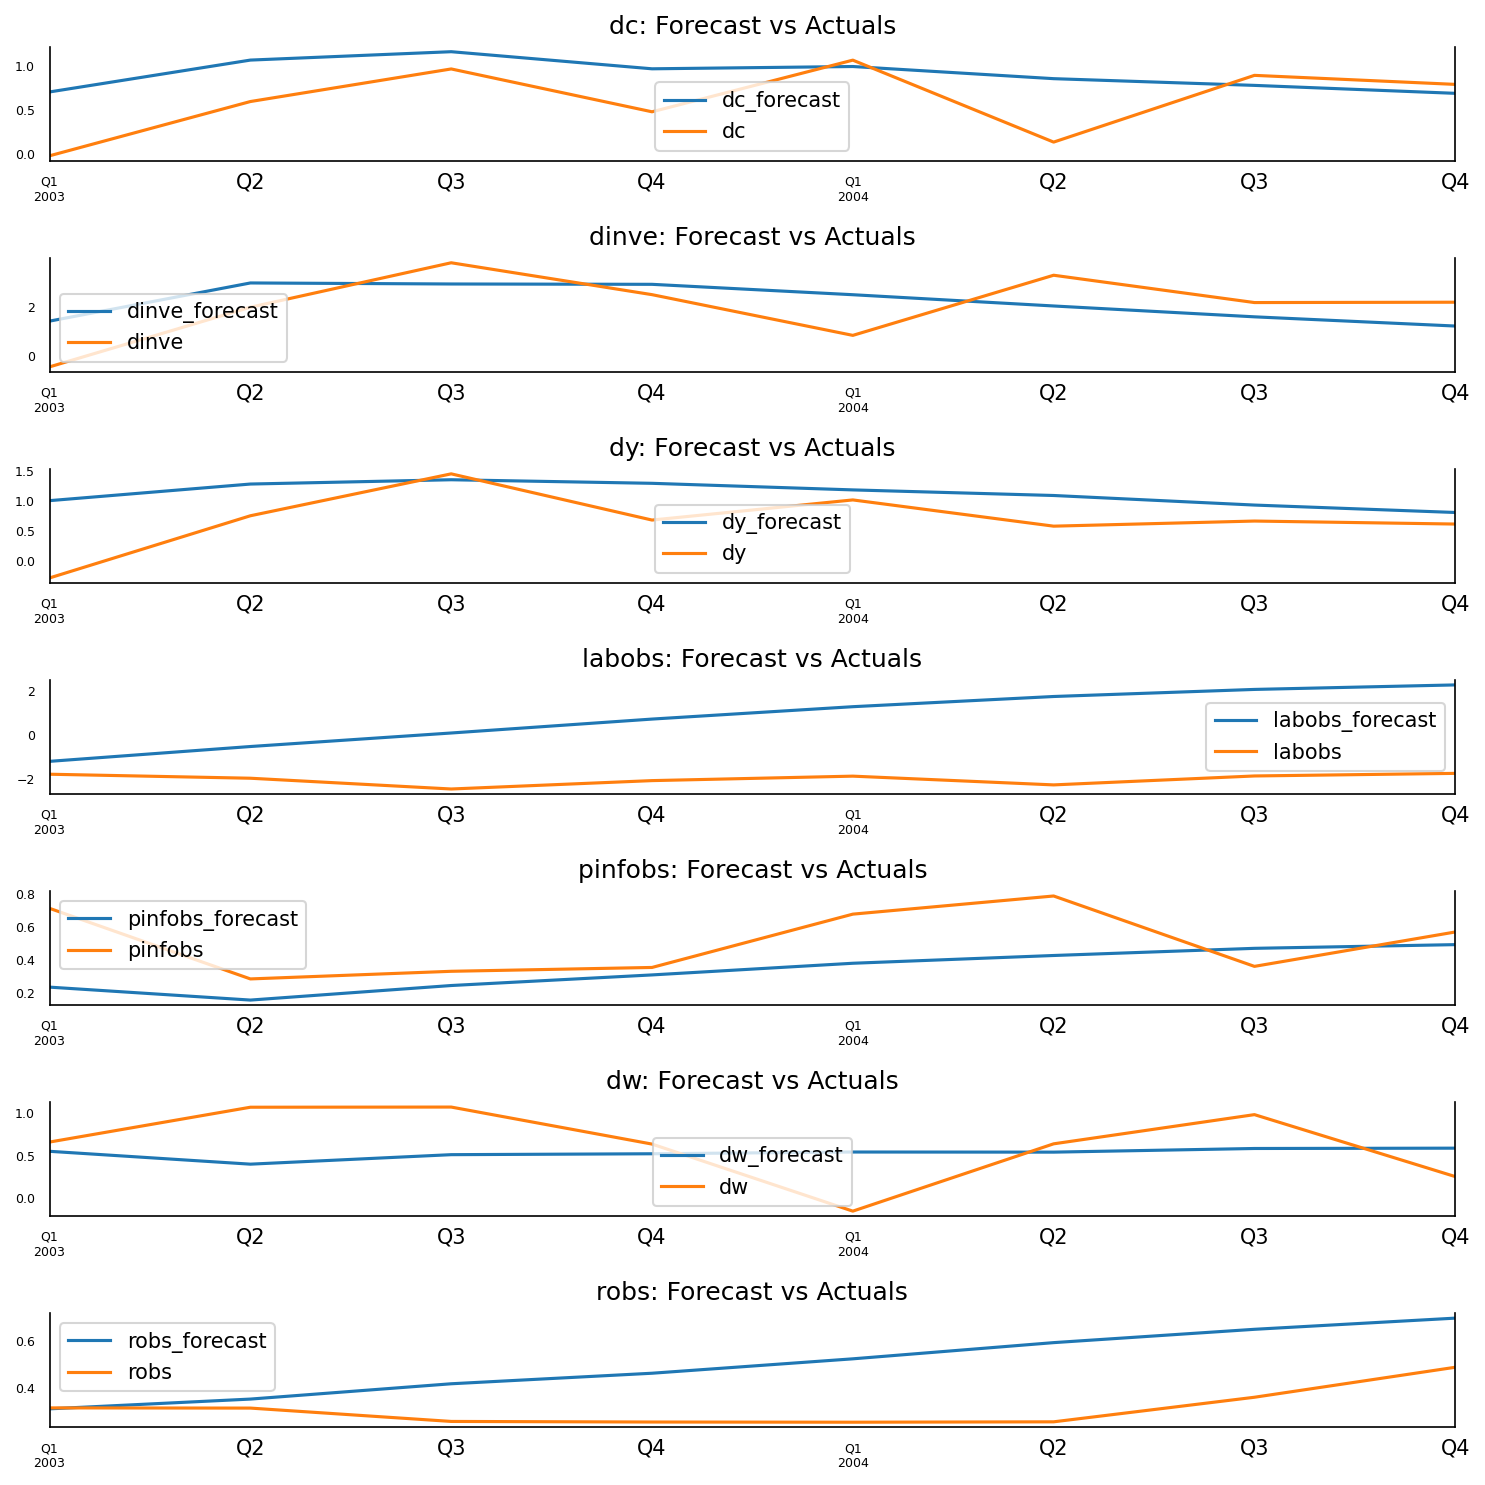

In [212]:
fig, axes = plt.subplots(nrows=int(len(data.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    data_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Evaluation

In [213]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mse = np.mean((forecast - actual)**2)  # MSE
    return({ 'mse':mse})

print('Forecast Accuracy of: dc')
accuracy_prod = forecast_accuracy(data_forecast['dc_forecast'].values, test['dc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dinve')
accuracy_prod = forecast_accuracy(data_forecast['dinve_forecast'].values, test['dinve'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dy')
accuracy_prod = forecast_accuracy(data_forecast['dy_forecast'].values, test['dy'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: labobs')
accuracy_prod = forecast_accuracy(data_forecast['labobs_forecast'].values, test['labobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pinfobs')
accuracy_prod = forecast_accuracy(data_forecast['pinfobs_forecast'].values, test['pinfobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dw')
accuracy_prod = forecast_accuracy(data_forecast['dw_forecast'].values, test['dw'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: robs')
accuracy_prod = forecast_accuracy(data_forecast['robs_forecast'].values, test['robs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: dc
mse :  0.1954

Forecast Accuracy of: dinve
mse :  1.3465

Forecast Accuracy of: dy
mse :  0.3412

Forecast Accuracy of: labobs
mse :  9.4155

Forecast Accuracy of: pinfobs
mse :  0.0615

Forecast Accuracy of: dw
mse :  0.1942

Forecast Accuracy of: robs
mse :  0.0492


# Machine learning models

## Train-validation-test split

We only have one time series in total, to be transformed first into train, validation and test sets and then into a supervised learning problem. I shall not randomly split the data into train and validation sets, for efficient use of the data and to prevent leakage. For the train and validation sets, I will split them into overlapping windows of equal lenghs, with the time difference of 1 quarter. Those windows are of the length n_steps + nobs, where n_steps refers to the number of lags and nobs refers to the forecast values. 

In [231]:
n_steps = 30
n_valid = 16
n = data.shape[0]
d = data.shape[1]
n_train = n - nobs - n_valid

In [232]:
X_test, Y_test = data[-nobs-n_steps:-nobs], data[-nobs:]
test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

## Splitting into subsequences

We choose to return sequence as output at each step, instead of vector. To be more exact, at timestep 0 the model predicts periods 1-8, and at timestep 1 the model predicts periods 2-9, until the last timestep. The input is a 3D array of (sample size, time steps, features). The target, as windows for each timestep in the input, should be a 4D array, with one more dimension "nobs". However, the sequential api only takes in 3D arrays. In fact, only the first two arguments need to be identified as they have to match the weight matrices. So I just have to merge the last 2 dimensions in the target into 1 dimension, keeping in mind of the items in different positions. For instance, for the input, in the vertical direction lies the features for each sample. I create the target so that features for different forward-looking periods are stacked together. 

In [233]:
# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

In [234]:
X_train.shape, Y_train.shape

((168, 30, 7), (168, 30, 56))

In [235]:
# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

In [236]:
X_valid.shape, Y_valid.shape

((8, 30, 7), (8, 30, 56))

In [237]:
# Split test set into subsequences
X_test = np.array(data[-nobs-n_steps:-nobs])
Y_test = np.empty((n_steps, d * nobs))
for j in range(nobs):
    Y_test[:, j*d : (j+1)*d] = test[j+1 : j+n_steps+1]

In [238]:
X_test.shape, Y_test.shape

((30, 7), (30, 56))

In [239]:
X_test = X_test.reshape(1, n_steps, d)
Y_test = Y_test.reshape(1, n_steps, d * nobs)

In [240]:
X_test.shape, Y_test.shape

((1, 30, 7), (1, 30, 56))

## Normalization

MinMaxScaler from sklearn can only normalize against 2D arrays. Here I am normalizing along the 3rd axis--in other words, across the 1st and 2nd axis. Therefore I normalize the data like below:

In [241]:
X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

In [242]:
Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

## RNN

In [243]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 7]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [244]:
model.compile(loss='mse', optimizer='adam')

In [245]:
model.fit(X_train_norm, Y_train_norm, epochs = 100)

Epoch 1/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3091
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2177
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1722
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1329
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0985
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0732
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0567
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0467
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0369
Epoch 11/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 13/100
6/6 [==============================] - 0s 4ms/st

In [246]:
X_test_norm = (X_test - X_min)/(X_max - X_min)

In [247]:
Y_pred = model.predict(X_test_norm)

In [248]:
Y_pred = Y_pred * (Y_max - Y_min) + Y_min

In [249]:
Y_pred.shape

(1, 30, 56)

We are only interested in the output from the last time step. And the output is made up of 8 periods of 7 features. To compute the MSE, I do the following reshape.

In [250]:
Y_pred = Y_pred[:, -1, :].reshape(nobs, d)

In [251]:
Y_test = Y_test[:, -1, :].reshape(nobs, d)

In [253]:
np.mean((Y_pred - Y_test)**2, axis = 0)

array([ 0.21655297,  2.77370845,  0.24879975, 12.10407547,  0.03257293,
        0.21544258,  0.13590053])

## LSTM

We currently have 30 timesteps. But in general the gradient vanishes after 10 timesteps. Therefore we try to see if LSTM gives us a better result.

In [147]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 7]),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [148]:
model.compile(loss='mse', optimizer='adam')

In [149]:
model.fit(X_train_norm, Y_train_norm, epochs = 100)

Epoch 1/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2219
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1937
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1632
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1329
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1097
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0898
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0741
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0622
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0533
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0471
Epoch 11/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0430
Epoch 12/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0403
Epoch 13/100
6/6 [==============================] - 0